In [1]:
import wntr
from scripts.valves import ValveStates,create_valvestates
from scripts.segment import *
from scripts.valves import *

In [2]:
class HydroSegmentNet(object):
    def __init__(self,vstates,src_pids):
        self.vstates = vstates
        
        self.segments = simulate_segments(self.vstates)
        self.sid2index = self._init_sid2index()
        self.nid2seg = get_nid2seg_dict(self.segments)
        self.pid2seg = get_pid2seg_dict(self.segments)
        self.src_segments = self._get_src_segments(src_pids)
        self.seg_adj_mtx = self._init_seg_adj_mtx()
    
    def _init_sid2index(self):
        sid2index = {}
        for i, seg in enumerate(self.segments):
            sid2index[seg.sid] = i
        return sid2index
    
    def _init_seg_adj_mtx(self):
        A = np.zeros((len(self.segments),len(self.segments)))
        linking_valves = self.vstates.normal_valves+self.vstates.white_valves
        for v in linking_valves:
            seg0 = self.nid2seg[v.nid]
            seg1 = self.pid2seg[v.pid]
            A[seg0.sid,seg1.sid] = 1
            A[seg1.sid,seg0.sid] = 1 # symmetry
        return A 
    
    def _get_src_segments(self,src_pids):
        src_segments = []
        for src_pid in src_pids:
            src_segments.append(self.pid2seg[src_pid])
        return src_segments

    def _adjust_index_mapping(self,sindex2delete):
        # sid2index 
        for sid,sindex in self.sid2index.items():
            if sindex:
                if sindex > sindex2delete:
                    self.sid2index[sid] -= 1
                elif sindex== sindex2delete:
                    self.sid2index[sid] = None
                    
        # nid/pid mappings
        self.nid2seg = get_nid2seg_dict(self.segments)
        self.pid2seg = get_pid2seg_dict(self.segments)
        
    def _adjust_seg_adj_mtx(self,sindex2delete,sindex2merge):
        self.seg_adj_mtx[sindex2merge,:] += self.seg_adj_mtx[sindex2delete,:]
        self.seg_adj_mtx[:,sindex2merge] += self.seg_adj_mtx[:,sindex2delete]
        
        self.seg_adj_mtx = np.delete(self.seg_adj_mtx,sindex2delete,0)
        self.seg_adj_mtx = np.delete(self.seg_adj_mtx,sindex2delete,1)
        
                
    def _merge_segment(self,seg_from,seg_to):
        seg_to += seg_from 
        
        sindex2delete = self.sid2index[seg_from.sid]
        sindex2merge = self.sid2index[seg_to.sid]
        self.segments.pop(sindex2delete)
        
        self._adjust_seg_adj_mtx(sindex2delete,sindex2merge)
        self._adjust_index_mapping(sindex2delete)
        
        sindex2merge = self.sid2index[seg_to.sid] # index mapping has changed
        return seg_to
        
    def valve_fail(self):
        failed_valve = self.vstates.fail_valves(1)[0]
        seg_from = self.nid2seg[failed_valve.nid]
        seg_to = self.pid2seg[failed_valve.pid]
        if seg_from != seg_to:
            merged_segment = self._merge_segment(seg_from,seg_to)
            
    @property 
    def vfail_rate(self):
        return self.vstates.fail_rate
        
        
        
def get_nid2seg_dict(segments):
    nid2seg = {}
    for seg in segments:
        for nid in seg.nids:
            nid2seg[nid] = seg
    return nid2seg

def get_pid2seg_dict(segments):
    pid2seg = {}
    for seg in segments:
        for pid in seg.pids:
            pid2seg[pid] = seg
    return pid2seg
        
            
            

In [3]:
def get_valid_segments(segnet,src_nid):
    valid_segs = []
    for segment in segnet.segments:
        if src_nid not in segment.nids:
            if len(segment.pids) > 0:
                valid_segs.append(segment)
    return valid_segs
    
def get_segment_pnames(valid_segs):
    segment_pnames = []
    for segment in valid_segs:
        pids = segment.pids
        pnames = [lid2lname[pid] for pid in pids]
        segment_pnames.append(pnames)
    return segment_pnames

def get_segment_nnames(valid_segs):
    segment_nnames = []
    for segment in valid_segs:
        nids = segment.nids
        nnames = [nid2nname[nid] for nid in nids]
        segment_nnames.append(nnames)
    return segment_nnames
    

In [4]:
import os
import glob 
import multiprocessing as mp
import copy


def close_pipes(pipe_names,wn):
    for pipe_name in pipe_names:
        pipe = wn.get_link(pipe_name)        
        pipe.status = wntr.network.LinkStatus.Closed
    return wn

def open_pipes(pipe_names,wn):
    for pipe_name in pipe_names:
        pipe = wn.get_link(pipe_name)        
        pipe.status = wntr.network.LinkStatus.Open
    return wn

def remove_demand(node_names,wn):
    demands = []
    for node_name in node_names:
        demand = copy.deepcopy(wn.get_node(node_name).demand_timeseries_list[0].base_value)
        demands.append(demand)
        wn.get_node(node_name).demand_timeseries_list[0].base_value = 0
    return demands,wn

def restore_demand(node_names,demands,wn):
    for node_name,demand in zip(node_names,demands):
        wn.get_node(node_name).demand_timeseries_list[0].base_value = demand
    return wn
    
def isolate_pipes(pipe_names,node_names,wn):
    wn = close_pipes(pipe_names,wn)
    demands, wn = remove_demand(node_names,wn)
    sim = wntr.sim.EpanetSimulator(wn)
    
    np.random.seed()
    rand_name = './temp/'+str(np.random.randint(1e9))
    try:
        results = sim.run_sim(file_prefix=rand_name)
    except:
        print ('Issues when running hydrualic simulation, use the initial result')
        results = init_result
    wn = open_pipes(pipe_names,wn)
    wn = restore_demand(node_names,demands,wn)
    return results

def remove_temps():
    temp_files = glob.glob("./temp/*")
    for file in temp_files:
        os.remove(file)
        
def hydrau_segments_sim(valid_segments):
    segment_pnames = get_segment_pnames(valid_segments)
    segment_nnames = get_segment_nnames(valid_segments)
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.starmap(isolate_pipes, [(pipe_name,node_name,wn) for pipe_name,node_name 
                                           in zip(segment_pnames,segment_nnames)])
    pool.close()
    remove_temps()
    return results
    
    
def find_direct_loses(valid_segments,init_demand):
    direct_loses = []
    for segment in valid_segments:
        direct_lose = []
        for nid in segment.nids:
            nname = nid2nname[nid]
            demand = init_demand[nname].to_numpy()[0]
            direct_lose.append ((nname,max(demand,0)))
        direct_loses.append(direct_lose)
    return direct_loses
        

In [5]:
def analyze_drop_ratio(dvals,init_vals,keys,thre = -0.1):
    drop_cond = dvals < thre
    drop_ratio = abs(dvals[drop_cond]/init_vals[drop_cond])*100
    impacted_keys = keys[drop_cond]
    drops = [(key,drop) for key, drop in zip(impacted_keys,drop_ratio)]
    return drops

def analyze_drop(dvals,init_vals,keys,thre = -0.1):
    drop_cond = dvals < thre
    drops = abs(dvals[drop_cond])
    impacted_keys = keys[drop_cond]
    drops = [(key,drop) for key, drop in zip(impacted_keys,drops)]
    return drops

def find_hydrau_loses(init_result,hydrau_results):
    init_pressure = init_result.node['pressure'].to_numpy().flatten()
    init_demand = init_result.node['demand'].to_numpy().flatten()
    keys = init_result.node['pressure'].keys().to_numpy().flatten()
    pressure_loses,demand_loses = [],[]
    
    for res in hydrau_results:
        pressure = res.node['pressure'].to_numpy().flatten()
        demand = res.node['demand'].to_numpy().flatten()
        pressure = [p if p >0 else 0 for p in pressure]
        demand = [d if d >0 else 0 for d in demand]
        dp = pressure-init_pressure
        pressure_drop = analyze_drop(dp,init_pressure,keys)
        pressure_loses.append(pressure_drop)

        dd = demand-init_demand
        demand_drop = analyze_drop(dd,init_demand,keys,-1e-6)
        demand_loses.append(demand_drop)
    return pressure_loses,demand_loses

def fail_valves(segnet,fail_rate):
    num_valves = len(segnet.vstates.valid_valves)
    nv2fail = int(num_valves*fail_rate)
    for i in range (nv2fail):
        segnet.valve_fail()
    return segnet
    
    
    

In [6]:
def summarize_loses(loses):
    tot_lose = []
    for lose in loses:
        lose_sum = 0
        if len(lose):
            for k,l in lose:
                lose_sum+=l
        tot_lose.append(lose_sum)
    return tot_lose

def init_costs(wn):
    pname2pcost = {}
    pname2dcost = {}
    for pipe_name in wn.pipe_name_list:
        pname2pcost[pipe_name] = 0
        pname2dcost[pipe_name] = 0
    return pname2pcost,pname2dcost
    
    
def update_cost(pressure_costs,demand_costs,valid_segments,
               pname2pcost,pname2dcost):
    for i in range(len(valid_segments)):
        segment = valid_segments[i]
        pressure_cost = pressure_costs[i]
        demand_cost = demand_costs[i]
        for pid in segment.pids:
            pname = lid2lname[pid]
            pname2pcost[pname] += pressure_cost
            pname2dcost[pname] += demand_cost
    return pname2pcost,pname2dcost


/home/rewu/Documents/research/valves/wntr/epanet/io.py:2173: UserWarning: Not all curves were used in "./data/hill.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
/home/rewu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(<matplotlib.collections.PathCollection at 0x7f598c92a6d8>,
 <matplotlib.collections.LineCollection at 0x7f598d1b1128>)

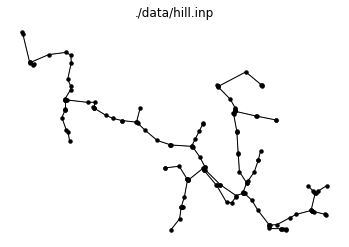

In [7]:
# Create a water network model
inp_file = './data/hill.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'

wntr.graphics.plot_network(wn, title=wn.name)

In [8]:
nname2nid = {}
nid2nname = {}
for nid,nname in enumerate(wn.node_name_list):
    nname2nid[nname] = nid
    nid2nname[nid] = nname
    
lid2nids = {}
lname2lid = {}
lid2lname = {}

for lid,pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    n1_name = pipe.start_node_name
    n2_name = pipe.end_node_name
    lname2lid[pipe.name] = lid
    lid2lname[lid] = pipe.name
    
    lid2nids[lid] = (nname2nid[n1_name],nname2nid[n2_name])

In [9]:
lid2lname

{0: '101860',
 1: '13813',
 2: '13814',
 3: '13815',
 4: '13817',
 5: '14358',
 6: '14437',
 7: '14438',
 8: '14439',
 9: '14440',
 10: '14441',
 11: '14442',
 12: '14444',
 13: '14445',
 14: '14446',
 15: '14447',
 16: '2034654',
 17: '2034797',
 18: '2167291',
 19: '2168021',
 20: '2168216',
 21: '2168494',
 22: '2168513',
 23: '2169164',
 24: '2169384',
 25: '2169526',
 26: '2169677',
 27: '2170367',
 28: '2170453',
 29: '2170616',
 30: '2170648',
 31: '2171540',
 32: '2171943',
 33: '2172038',
 34: '2172348',
 35: '2172442',
 36: '2172548',
 37: '2172882',
 38: '2172954',
 39: '2173345',
 40: '2173807',
 41: '2173844',
 42: '2174319',
 43: '2174588',
 44: '2174807',
 45: '2175466',
 46: '2175553',
 47: '2176313',
 48: '2177131',
 49: '2177157',
 50: '2177258',
 51: '2177296',
 52: '2177573',
 53: '2178040',
 54: '2178214',
 55: '2178419',
 56: '2178430',
 57: '2178812',
 58: '2179416',
 59: '2179573',
 60: '2179709',
 61: '2179739',
 62: '2179982',
 63: '2180156',
 64: '2180752',
 

In [10]:
def cost_analysis(wn,vfail_rate,segnet):
    segnet = copy.deepcopy(segnet)
    segnet = fail_valves(segnet,vfail_rate)
    
    sim = wntr.sim.EpanetSimulator(wn)
    rand_name = './temp/'+str(np.random.randint(1e6))
    init_result = sim.run_sim(file_prefix=rand_name)
    pname2pcost,pname2dcost = init_costs(wn)
    
    valid_segments = get_valid_segments(segnet,161)
    init_demand = init_result.node['demand']
    direct_loses = find_direct_loses(valid_segments,init_demand)
    hydrau_results = hydrau_segments_sim(valid_segments)
    pressure_loses,demand_loses = find_hydrau_loses(init_result,hydrau_results)
    pressure_costs,demand_costs = summarize_loses(pressure_loses),summarize_loses(demand_loses)
    
    pname2pcost,pname2dcost = update_cost(pressure_costs,demand_costs,
                                          valid_segments,pname2pcost,pname2dcost)
    return pname2pcost,pname2dcost
    
    
def average_cost(cost,num_sim):
    avg_cost = {}
    for k,item in cost.items():
        item = item/num_sim
        avg_cost[k] = item
    return avg_cost

def mc_cost(wn,vfail_rate,segnet,num_sim):
    tot_pcost,tot_dcost = init_costs(wn)
    for i in range(num_sim):
        pname2pcost,pname2dcost = cost_analysis(wn,vfail_rate,segnet)  
        for pname in wn.pipe_name_list:
            tot_pcost[pname] += pname2pcost[pname]
            tot_dcost[pname] += pname2dcost[pname]
    avg_pcost = average_cost(tot_pcost,num_sim)
    avg_dcost = average_cost(tot_dcost,num_sim)
    
    return pname2pcost,pname2dcost
    

In [11]:
inp_file = './data/hill.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'

sim = wntr.sim.EpanetSimulator(wn)
rand_name = './temp/'+str(np.random.randint(1e6))
init_result = sim.run_sim(file_prefix=rand_name)

In [12]:
tot_demand = init_result.node['demand'].to_numpy().flatten()[:-1].sum()
tot_demand

0.0038873975

In [13]:
def sum_cost(cost_dict):
    tot = 0
    for k,cost in cost_dict.items():
        tot+= cost
    return tot

In [14]:
src_pids = [161]
N1 = False
vstate = create_valvestates(lid2nids,src_pids,N1)
segnet = HydroSegmentNet(vstate,src_pids)

In [15]:
# pcost0,dcost0,segnet0,hydrau_results0 = cost_analysis(wn,0,segnet)
# pcost1,dcost1,segnet1,hydrau_results1 = cost_analysis(wn,0.15,segnet)

In [16]:
# pcost,dcost,tot_dcost = mc_cost(wn,0.15,segnet,100)

In [17]:
# dp = {}
# dd = {}

# for pipe_name in wn.pipe_name_list:
#     dpp = pcost1[pipe_name]-pcost0[pipe_name]
#     if dpp <-100:
#         print (pipe_name,dpp)
#     dp[pipe_name] = dpp
#     dd[pipe_name] = (dcost1[pipe_name]-dcost0[pipe_name])

In [18]:
# seg1 = segnet1.pid2seg[lname2lid['87303']]
# seg0 = segnet0.pid2seg[lname2lid['87303']]

# print (seg0)
# print (seg1)
# print (pcost0['87303'],pcost1['87303'])

In [19]:
# def find_seg_idx(valid_segs,sid):
#     for i,seg in enumerate(valid_segs):
#         if seg.sid == sid:
#             return i

In [20]:
# valid_seg0 = get_valid_segments(segnet0,161)
# valid_seg1 = get_valid_segments(segnet1,161)


# id0 = find_seg_idx(valid_seg0,129)
# id1 = find_seg_idx(valid_seg1,129)

In [21]:
# res0 = hydrau_results0[id0].node['demand']
# res1 = hydrau_results1[id1].node['demand']

In [22]:
num_sim = 200
fail_rates = [0,0.05,0.1,0.15,0.2,0.25]
pcosts = []
dcosts = []
for fail_rate in fail_rates:
    print (fail_rate)
    pcost,dcost = mc_cost(wn,fail_rate,segnet,num_sim)
    pcosts.append(pcost)
    dcosts.append(dcost)



0
0.05
0.1
0.15
0.2
0.25


In [23]:
def convert_costs_dict(costs):
    costs_list = []
    for cost_dict in costs:
        cost = [c for k, c in cost_dict.items()]
        costs_list.append(np.array(cost))
    return costs_list

pcosts = convert_costs_dict(pcosts)
dcosts = convert_costs_dict(dcosts)

In [24]:
from shapely.geometry import Point, LineString
import pandas as pd
import geopandas as gpd
import networkx as nx


def get_pipe_df(wn):
    G = wn.get_graph()
    pos = nx.get_node_attributes(G,'pos')

    lines = []
    pcost_list = []
    dcost_list = []
    for pipe_name in wn.pipe_name_list:
        pipe = wn.get_link(pipe_name)  
        start_node = pipe.start_node_name
        end_node = pipe.end_node_name

        loc_start = pos[start_node]
        loc_end = pos[end_node]
        l = LineString([Point(loc_start), Point(loc_end)])
        lines.append(l)
        
    df_dict = {'pipe_names':wn.pipe_name_list,
              'geometry':lines}
    df = pd.DataFrame.from_dict(df_dict)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf



In [25]:
pipe_data = get_pipe_df(wn)
tot_demand = init_result.node['demand'].to_numpy().flatten()[:-1].sum()

In [26]:
for dcost in dcosts:
    print((dcost/tot_demand).max())

0.9981162715392274
0.9981162715392274
0.9981162715392274
0.9981162715392274
0.9981162715392274
0.9981162715392274


In [27]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()

@interact
def plot_demand_cost(i=(0,len(fail_rates)-1,1)):
    dcost = dcosts[i]/tot_demand*100
    pipe_cost['dcost'] = dcost
    base = pipe_cost[pipe_cost['dcost']<3]
    others = pipe_cost[(pipe_cost['dcost']>3)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='dcost',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Demand Cost for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [28]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()
@interact
def plot_demand_cost_diff(i=(1,len(fail_rates)-1,1)):
    dcost_diff = (dcosts[i]-dcosts[0])/tot_demand*100
    pipe_cost['dcost_diff'] = dcost_diff
    base = pipe_cost[pipe_cost['dcost_diff']<1]
    others = pipe_cost[(pipe_cost['dcost_diff']>1)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='dcost_diff',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Demand Cost Increment for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=3, description='i', max=5, min=1), Output()), _dom_classes=('widget-inte…

In [29]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()

@interact
def plot_pressure_cost(i=(0,len(fail_rates)-1,1)):
    pcost = pcosts[i]
    pipe_cost['pcost'] = pcost
    base = pipe_cost[pipe_cost['pcost']<10]
    others = pipe_cost[(pipe_cost['pcost']>10)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='pcost',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Pressure Cost for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [30]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()
@interact
def plot_pressure_cost_diff(i=(1,len(fail_rates)-1,1)):
    pcost_diff = (pcosts[i]-pcosts[0])
    pipe_cost['pcost_diff'] = pcost_diff
    base = pipe_cost[pipe_cost['pcost_diff']<10]
    others = pipe_cost[(pipe_cost['pcost_diff']>10)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='pcost_diff',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Pressure Cost Increment for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=3, description='i', max=5, min=1), Output()), _dom_classes=('widget-inte…

In [34]:
(15750/2)/np.sin(np.pi/4)

11136.931803688125

In [36]:
5550 / ( 2.33E-5*2 * 445E-6)

267637556059.21783